In [1]:
import os
import cv2
import numpy as np
import datetime as dt

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D
from keras import Model
from keras.applications import vgg16
from keras.preprocessing import image as image_utils

import matplotlib.pyplot as plt
import scipy.io

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import file_locations

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1295673610693698531
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17340052666492678050
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10809931137551226072
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23692551783
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15423839297338471672
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


## Import Pretrained VGG16

In [2]:
#Take pretrained model
base_model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling='avg', classes=1000)
base_model.summary()











_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         


## Quick ImageNet Check

In [ ]:
image = image_utils.load_img("./data/kitty.jpg",target_size=(224, 224))
plt.imshow(image)
plt.title('kitty!')
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [ ]:
preds = base_model.predict(x)
decoded_preds = vgg16.decode_predictions(preds)
print('Predicted:', decoded_preds)

## Model customization for IMDB Pretrain

In [3]:
#finetuning model setup (might want to take those 2 fc's.. this is a lot of params)
PRETRAIN_NUM_CLASSES = 8

#K.set_learning_phase(0)

base_model = vgg16.VGG16(weights='imagenet', include_top=True, pooling = 'avg', classes=1000, input_shape=(224,224,3))

for layer in base_model.layers[:-3]:
    layer.trainable = False

x = base_model.layers[-2].output
hidden = Dense(2048, name='dense', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x) 
predictions = Dense(PRETRAIN_NUM_CLASSES, name='predictions', activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(hidden) 
model = Model(inputs=base_model.input, outputs=predictions)

#K.set_learning_phase(1)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Load IMDB-Age Dataset

In [6]:
import random;

images = [];
num_examples = [];
for i in range(1,PRETRAIN_NUM_CLASSES+1):
    filenames = random.sample(os.listdir(file_locations.PATH_TO_IMDB_AGE+"d"+str(i)+"0"),k=10)
    category_filenames = []
    for j in range(len(filenames)):
        category_filenames.append("/d"+str(i)+"0/"+filenames[j])
    images.append(category_filenames)
    num_examples.append(len(os.listdir(file_locations.PATH_TO_IMDB_AGE+"/d"+str(i)+"0")))

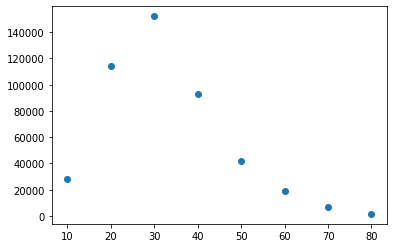

In [7]:
plt.scatter(np.array(range(1,len(num_examples)+1))*10,num_examples);

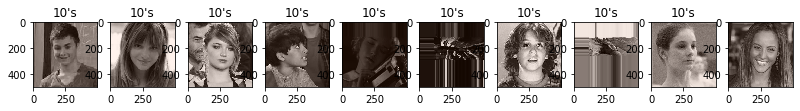

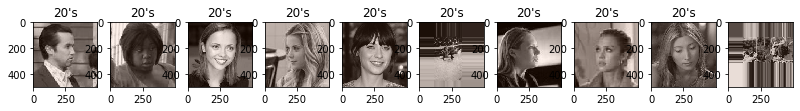

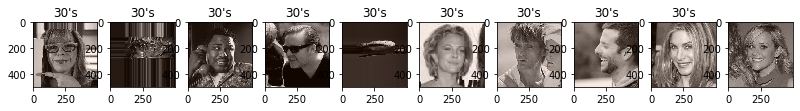

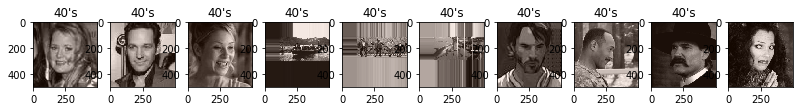

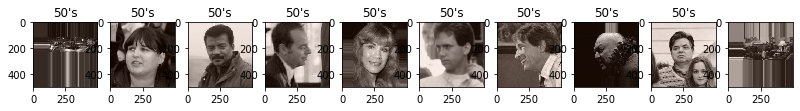

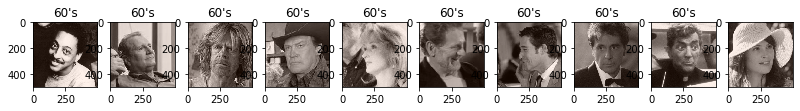

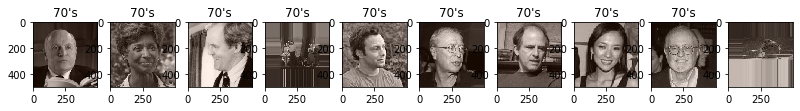

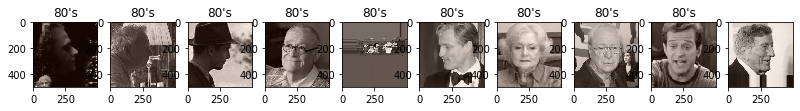

In [8]:
#image some classs exemplars from dataset
def preprocess_greyscale(x):
    return vgg16.preprocess_input(np.repeat(np.expand_dims(np.mean(x, -1),-1),3,axis=-1))

for i in range(len(images)):
    plt.figure(figsize=(15,15))
    for j in range(len(images[i])):
        plt.title(str(i+1) +"0's")
        image = image_utils.load_img(file_locations.PATH_TO_IMDB_AGE+images[i][j], target_size=(500,500))
        x = image_utils.img_to_array(image)
        x = np.expand_dims(x,0)
        x = preprocess_greyscale(x)
        
        plt.subplot(1,len(images[i])+1,j+1)
        plt.imshow(image_utils.array_to_img(x[0]))
        

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=0, 
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=False, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=preprocess_greyscale, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None)

In [10]:
BS = 256

train_it = datagen.flow_from_directory(file_locations.PATH_TO_IMDB_AGE, class_mode = 'categorical', batch_size=BS, target_size=(224,224), shuffle=True, subset='training', seed=1337)
val_it = datagen.flow_from_directory(file_locations.PATH_TO_IMDB_AGE, class_mode='categorical', batch_size=BS, target_size=(224,224), shuffle=True, subset='validation', seed=102439)

Found 365558 images belonging to 8 classes.
Found 91385 images belonging to 8 classes.


## Model Pre-re-training

In [11]:
#create directory for checkpoints and set name (only run this once to start)
model_filename = file_locations.PATH_TO_CHECKPOINTS+'{}'.format(dt.datetime.now().strftime("%Y.%m.%d-%H%M"))+'-imdbage'
os.mkdir(model_filename)
model_filename += '/'+model_filename.split('/')[-1]

model_number = 0;

### Finetune run

In [12]:
#callbacks to use during trinaing
cpcb = keras.callbacks.ModelCheckpoint(
    model_filename+str(model_number)+'.weights.hdf5', 
    monitor='val_categorical_accuracy', verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)

In [13]:
#choice of optimizer
#mx_opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.0005, nesterov=True)
model.compile(optimizer = "adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy']
             )

In [ ]:
#training
history = model.fit_generator(
    train_it,
    steps_per_epoch = train_it.samples*0.2 // BS,
    validation_data = val_it, 
    validation_steps = val_it.samples*0.2 // BS,
    epochs = 25,
    callbacks = [ cpcb, reduce_lr ],
    workers = 12
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
285/285 [==============================] - 574s 2s/step - loss: 14.3439 - categorical_accuracy: 0.2118 - val_loss: 11.9101 - val_categorical_accuracy: 0.3332

Epoch 00001: val_categorical_accuracy improved from -inf to 0.33319, saving model to /biac2/kgs/projects/deepRFs/checkpoints_vgg16/2020.02.24-0420-imdbage/2020.02.24-0420-imdbage0.weights.hdf5
Epoch 2/25
285/285 [==============================] - 547s 2s/step - loss: 10.9271 - categorical_accuracy: 0.3324 - val_loss: 10.8164 - val_categorical_accuracy: 0.3293

Epoch 00002: val_categorical_accuracy did not improve from 0.33319
Epoch 3/25
285/285 [==============================] - 562s 2s/step - loss: 13.0817 - categorical_accuracy: 0.2017 - val_loss: 15.0424 - val_categorical_accuracy: 0.0910

Epoch 00003: val_categorical_accuracy did not improve from 0.33319
Epoch 4/25
 69/285 [======>.......................] - ETA: 5:56 - l

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Pretraining Loss - Age")
plt.legend(["train","val"])
plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title("Pretraining Accuracy - Age")
plt.legend(["train","val"])
plt.savefig(model_filename+str(model_number)+".training.png")
plt.show()

In [ ]:
#save matlab file with training history for error bar construction later!
scipy.io.savemat(model_filename+str(model_number)+'.history.mat', history.history)

In [ ]:
#next!
model_number += 1;

### This pre-re-trained model is saved. Now finetune in either "Model Train TF1-Identity" or "Model Train TF1-Gender".